In [1]:
"""평균 회귀: 평균에 가까워지려는 경향"""

import FinanceDataReader as fdr
import pandas as pd
df = fdr.DataReader('AAPL', '1996')
df.head()    

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1996-01-02,0.29,0.29,0.29,0.28,139290000.0,0.0357
1996-01-03,0.29,0.29,0.29,0.28,429830000.0,0.0000
1996-01-04,0.28,0.29,0.29,0.28,300180000.0,-0.0345
1996-01-05,0.31,0.28,0.31,0.28,446040000.0,0.1071
1996-01-08,0.31,0.31,0.32,0.30,121340000.0,0.0000


In [2]:
df_price = df.loc[:,['Close']].copy()
df_price.rename(columns={'Close' : 'Adj Close'}, inplace=True)
df_price.head()

,Adj Close
Date,
1996-01-02,0.29
1996-01-03,0.29
1996-01-04,0.28
1996-01-05,0.31
1996-01-08,0.31


In [3]:
"""
볼린저 밴드 함수
상단 밴드 = 중간 밴드 + 2*20일 이동 표준 편차
중간 밴드 = 20일 이동 평균선
하단 밴드 = 중간 밴드 - 2*20일 이동 표준 편차
"""
n = 20
sigma = 2
def bollinger_band(df, n, sigma):
    temp = df.copy()
    temp['center'] = df_price['Adj Close'].rolling(window=n).mean()
    temp['up'] = temp['center'] + sigma*df_price['Adj Close'].rolling(window=n).std()
    temp['down'] = temp['center'] - sigma*df_price['Adj Close'].rolling(window=n).std()
    return temp
    
bollinger = bollinger_band(df_price, n, sigma)
sample = bollinger.loc['2000-01-01':]
sample.head()

,Adj Close,center,up,down
Date,,,,
2000-01-03,1.00,0.9195,1.031792,0.807208
2000-01-04,0.92,0.9135,1.010459,0.816541
2000-01-05,0.93,0.9075,0.980877,0.834123
2000-01-06,0.85,0.9010,0.970252,0.831748
2000-01-07,0.89,0.8985,0.965393,0.831607


In [4]:
def create_trade_book(df):
    book = df[['Adj Close']].copy()
    book['trade'] = ''
    return book

book = create_trade_book(sample)
book.head()

,Adj Close,trade
Date,,
2000-01-03,1.00,
2000-01-04,0.92,
2000-01-05,0.93,
2000-01-06,0.85,
2000-01-07,0.89,


In [5]:
# 거래 전략: 상단 밴드 보다 위에 있으면 매도, 하단 밴드 보다 아래에 있으면 매수
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'up']:
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'Adj Close'] < sample.loc[i, 'down']:
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'
            else:
                book.loc[i, 'trade'] = 'buy'
        elif sample.loc[i, 'up'] >= sample.loc[i, 'Adj Close'] >= sample.loc[i, 'down']:
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'
            else:
                book.loc[i, 'trade'] = ''
    return book

book = tradings(sample, book)
book[book['trade'] == 'buy'].tail()

,Adj Close,trade
Date,,
2021-03-03,122.06,buy
2021-03-04,120.13,buy
2021-03-05,121.42,buy
2021-03-08,116.36,buy
2021-03-09,121.08,buy


In [6]:
# 전략 수익률
def returns(book):
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i,'trade'] == '':
            buy = book.loc[i, 'Adj Close']
            print('진입일: ', i, ' 진입가격: ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            print('청산일: ', i, ' 진입가격: ', buy, ' | long 청산가격: ', sell, 'return: ', round(rtn, 4))
        if book.loc[i, 'trade'] == '':
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn
        book.loc[i, 'acc return'] = acc_rtn
    
    print('Accumulated return: ', round(acc_rtn, 4))
    return round(acc_rtn, 4)

print(returns(book))

진입일:  2000-01-12 00:00:00  진입가격:  0.78
청산일:  2000-01-20 00:00:00  진입가격:  0.78  | long 청산가격:  1.01 return:  1.2949
진입일:  2000-04-12 00:00:00  진입가격:  0.98
청산일:  2000-06-20 00:00:00  진입가격:  0.98  | long 청산가격:  0.9 return:  0.9184
진입일:  2000-07-24 00:00:00  진입가격:  0.87
청산일:  2000-08-23 00:00:00  진입가격:  0.87  | long 청산가격:  0.97 return:  1.1149
진입일:  2000-09-22 00:00:00  진입가격:  0.93
청산일:  2001-01-04 00:00:00  진입가격:  0.93  | long 청산가격:  0.3 return:  0.3226
진입일:  2001-05-29 00:00:00  진입가격:  0.38
청산일:  2001-06-25 00:00:00  진입가격:  0.38  | long 청산가격:  0.43 return:  1.1316
진입일:  2001-07-18 00:00:00  진입가격:  0.37
청산일:  2001-10-11 00:00:00  진입가격:  0.37  | long 청산가격:  0.32 return:  0.8649
진입일:  2002-02-21 00:00:00  진입가격:  0.38
청산일:  2002-04-16 00:00:00  진입가격:  0.38  | long 청산가격:  0.46 return:  1.2105
진입일:  2002-04-26 00:00:00  진입가격:  0.41
청산일:  2002-08-19 00:00:00  진입가격:  0.41  | long 청산가격:  0.29 return:  0.7073
진입일:  2002-10-08 00:00:00  진입가격:  0.24
청산일:  2002-10-25 00:00:00  진입가격:  0.24  | long 청산가격

<AxesSubplot:xlabel='Date'>

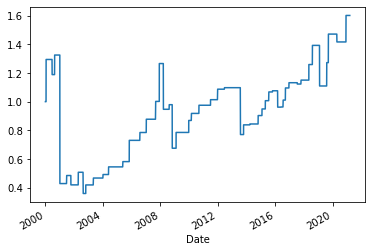

In [7]:
import matplotlib.pylab as plt
book['acc return'].plot()